# Evaluate / train models

First we import the necessary python modules and set the matplotlib parameters

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import autokeras as ak
from dti_util import tile2im, decode_dam, code_dam, get_score_importances, rmse, corr, unstack_training
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model
import yaml
import seaborn as sns
from scipy import stats


Set the experiment name and load the experiment setting

In [3]:
# Name of the experiment
name = 'exp4'

# Root of all directory used
rootdir = '/mnt/sfe-ns9602k/Julien/data'

# Directory of the experiment outputs
expdir = os.path.join(rootdir, name)

# Load experiment parameters
with open(os.path.join(expdir,'data_params.yml' )) as file:
    exp_dict = yaml.load(file, Loader=yaml.FullLoader)
    
# Print experiments parameters
for key, value in exp_dict.items():
    print(key, ' : ', value)
    
# Set the used parameters
traindir = exp_dict['traindir']
epsi = exp_dict['epsi']
th_dam = exp_dict['th_dam']
th_sit = exp_dict['th_sit']
dsize = exp_dict['dsize']
colnames = exp_dict['colnames']

colnames  :  ('log_deformation_0', 'log_deformation_1', 'c', 'h')
datadir  :  /mnt/sfe-ns9602k/Julien/data/anton/shom5km_defor_4cnn
dsize  :  25
end_train  :  400
epsi  :  0.01
itest  :  1
name  :  exp4
othernames  :  ('c',)
rootdir  :  /mnt/sfe-ns9602k/Julien/data
start_train  :  10
strides  :  20
th_dam  :  0.8
th_sic  :  0.9
th_sit  :  0.0
traindir  :  /mnt/sfe-ns9602k/Julien/data/exp4/train


Additional setting for the model

In [4]:

# Name of the model
model_name = "long-class"
#model_name = "demo-class"

# Read model setting parameter from file
from_file = True

# pretrained model ( if False, launch a new training)
pretrained = True

# Directory to stores the model
model_dir = os.path.join(expdir, model_name)

# Create the model directory if necessary
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Dictionnary sotring all the mod setting parameters
dmod = dict()

# Default values (are used for backward compatibility)
default_mod = {
    'type': 'reg'
}

if from_file:
    # Read model parameters from yml file
    with open(os.path.join(model_dir,'model_params.yml' )) as file:
        dmod = yaml.load(file, Loader=yaml.FullLoader)   
    dmod = {**default_mod, **dmod}
else:
    # Create a yml file
    
    # Type of model (reg or class)
    dmod['type'] = 'class'
    
    # If mod is 'class', target threshold value
    dmod['target_th'] = .95
    
    # relative size of the validation dataset
    dmod['test_size'] = 0.15

    # Seed of the train/val random split
    dmod['split_seed'] = 1

    # log_dir for tensorboard
    # log_dir is hardcoded because of NIRD toolkit, how to get the log name automatically?
    dmod['log_dir'] = "/mnt/sfe-ns9602k/.tools/deep-learn-1603280065-tensorboard/autokeras/{}-{}".format(name, model_name)

    # Shuffle score file name 
    dmod['fname_score_shuffle'] = 'shuffle_score'

    # Saliency score file name 
    dmod['fname_score_saliency'] = 'saliency_score'

    # Patience of the early stopping
    dmod['patience'] = 15 #15 #5

    # number of epochs
    dmod['epochs'] = 300

    # Number of trials of the model experiment
    dmod['max_trials'] = 10 #50 #3

    # Size of the training set (None for selecting all the training set)
    dmod['ntrain']= None #None #10000
    
    
    

    # Save the dictionary in yaml format
    with open(os.path.join(model_dir,'model_params.yml'),'w') as file:
        yaml.dump(dmod, file)

        
print ('--- MODEL CONFIGURATION ---')
for key, value in dmod.items():
    print(key, ' : ', value)

--- MODEL CONFIGURATION ---
type  :  class
epochs  :  300
fname_score_saliency  :  saliency_score
fname_score_shuffle  :  shuffle_score
log_dir  :  /mnt/sfe-ns9602k/.tools/deep-learn-1603280065-tensorboard/autokeras/exp4-long-class
max_trials  :  10
ntrain  :  None
patience  :  15
split_seed  :  1
target_th  :  0.95
test_size  :  0.15


Define the output normalization/denormalization

In [5]:
# Normalization function
norm = lambda x : code_dam(x,epsi=epsi, vmin=th_dam)

# Denormalization function
denorm = lambda x : decode_dam(x,epsi=epsi, vmin=th_dam)

Plot options:

In [6]:
lims = {
    'log_deformation_0': (-4, 1),
    'log_deformation_1': (-4, 1),
    'h':(th_sit,5),
    'c':(0,1),
    'damage_n' : [norm(1),norm(th_dam)],
    'damage' : [th_dam, 1]

}

## 1. Load datasets

In [7]:
data = np.load(os.path.join(traindir,'train.npz'))
X = data['Xtrain']
y = data['ytrain']
mask_train = data['mask_train']
yd = denorm(y)

In [8]:
print(f"Number of training samples: {X.shape[0]}")
print(f'Size of input feature: {X.shape[1:]}')

Number of training samples: 81066
Size of input feature: (25, 25, 4)


Split the training set into train and validation

In [9]:
Xtrain, Xval, ytrain, yval = train_test_split(X.astype(np.float32), yd.astype(np.float32),
                                                    test_size = dmod['test_size'],
                                                    random_state = dmod['split_seed'])

print(f"Number of training samples: {Xtrain.shape[0]}")
print(f"Number of validation samples: {Xval.shape[0]}")
ytrain_c = ytrain > dmod['target_th']
yval_c = yval > dmod['target_th']
c_th = dmod['target_th']

print(f"Number of damage in val <= {c_th}: {np.sum(~yval_c)}")
print(f"Number of damage in val > {c_th}: {np.sum(yval_c)}")

Number of training samples: 68906
Number of validation samples: 12160
Number of damage in val <= 0.95: 6757
Number of damage in val > 0.95: 5403


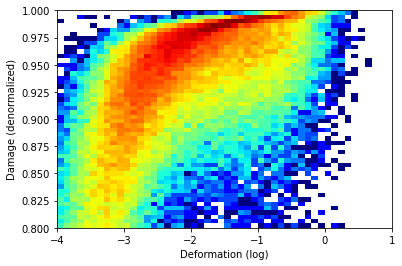

In [10]:
fig, ax = plt.subplots()
xx = Xtrain[:,dsize//2,dsize//2,0].ravel()
yy = ytrain.ravel()

ax.hist2d(xx,yy,  50, [lims['log_deformation_0'],lims['damage'] ], norm=matplotlib.colors.LogNorm(), cmap='jet');
ax.set_xlabel('Deformation (log)')
ax.set_ylabel('Damage (denormalized)');

## 2. Baseline

Two baseline are defined. Anton baselinee: ```reg_ak``` and Julien baseline: ```reg_jb```
Both baseline take the collocated deformation (scalar variable) as a predictor for the damage.
Julien's baseline is based on a polynomail regression of degree 2 based on hand-made points

In [11]:
# TODO: Improve this

def reg_ak(dd):
    return np.clip(1.01 - 0.008/(10**dd)**0.3,0,1)>dmod['target_th']

xpoint = np.array([-3, -2.5, -2, -1.5, -1,  0])
ypoint = np.array([.72, .25, -0.2, -.5, -0.7, -0.9])
coef = np.polyfit(xpoint, ypoint, 2)
print (f'Coefficients of the polynomial fit: {coef}')

def reg_jb(x):
    y = np.poly1d(coef)(x)
    lim = -coef[1]/(2*coef[0])
    y[x>lim] = np.poly1d(coef)(lim)
    y[x<-3.3] = np.poly1d(coef)(-3.3)
    return denorm(y)>dmod['target_th']



Coefficients of the polynomial fit: [ 0.18095238  0.00257143 -0.89595238]


Compute the predictions by the two baselines for regular spaced deformation

In [12]:
xlin = np.linspace(lims['log_deformation_0'][0],lims['log_deformation_0'][1],100)

y_ak_lin = reg_ak(xlin)
y_jb_lin = reg_jb(xlin)


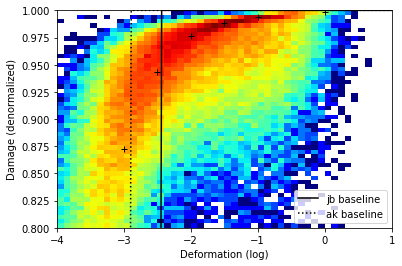

In [13]:
fig, ax = plt.subplots()
xx = Xtrain[:,dsize//2,dsize//2,0].ravel()
yy = ytrain.ravel()

ax.hist2d(xx,yy,  50, [lims['log_deformation_0'],lims['damage'] ], norm=matplotlib.colors.LogNorm(), cmap='jet');
ax.set_xlabel('Deformation (log)')
ax.set_ylabel('Damage (denormalized)');

ax.plot(xpoint,denorm(ypoint),'+k')
ax.plot(xlin,y_jb_lin,'-k',label="jb baseline")
ax.plot(xlin,y_ak_lin,':k',label="ak baseline")

ax.legend(loc='lower right')

## 3. Load/train model

In [14]:
if pretrained: 
    model = load_model(os.path.join(model_dir,model_name))
else: # To be used only for demo otherwise use the scrit run_script.py
   
    # Definition of the model search
    input_node = ak.ImageInput()
    out_node = ak.Normalization()(input_node)
    out_node = ak.ConvBlock()(out_node)
    #out_node2 = ak.XceptionBlock()(out_node)
    #out_node3 = ak.ResNetBlock()(out_node)
    #out_node = ak.Merge()([out_node1, out_node2, out_node3])
    if dmod['type']=='reg':
        raise NotImplementedError('Use the regression notebook')
    output_node = ak.ClassificationHead()(out_node)

    
    reg  = ak.AutoModel(
        inputs=input_node, outputs=output_node, 
        overwrite=True, 
        max_trials=dmod['max_trials'],
        project_name = 'reg',
        directory=model_dir
    )
    
    # Callback for logging
    tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=dmod['log_dir'], histogram_freq=2)
    
    # Callback for earlystopping (important, otherwise autonatic setups are applied in a final fit)
    early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=dmod['patience'],
    min_delta=1e-4,
    verbose=1,
    restore_best_weights=True
)
    
    # Fit the model
    reg.fit(
        Xtrain[:dmod['ntrain']],
        ytrain_c[:dmod['ntrain']],
        validation_data=(Xval, yval_c),
        epochs = dmod['epochs'],
        callbacks=[tensorboard_callback, early_stopping_monitor]
        )
    
    # Export and save the best model
    model = reg.export_model()
    model.save(os.path.join(model_dir,model_name), save_format="tf")

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 4)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 25, 25, 4)         0         
_________________________________________________________________
normalization (Normalization (None, 25, 25, 4)         9         
_________________________________________________________________
separable_conv2d (SeparableC (None, 23, 23, 32)        196       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 21, 21, 128)       4512      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 128)      

## 4. Evaluate the model on the validation set

In [16]:
# Evaluation of the model (on the normalized output)
model.evaluate(Xval, yval_c, batch_size=20)


608/608 [==============================] - 1s 2ms/step - loss: 0.4902 - accuracy: 0.7507


[0.4902365505695343, 0.7506579160690308]

In [17]:
# Model prediction on the validation dataset (denormalized)

ypredict = model.predict(Xval)
y_nn = np.where(ypredict > 0.5, True, False)



In [18]:
# Simple regressions predictions

y_ak = reg_ak(Xval[:,dsize//2,dsize//2,0])
y_jb = reg_jb(Xval[:,dsize//2,dsize//2,0])



Scatter plots of the different predictors

In [19]:
mask = None
target_names=[f'd<={c_th}',f'd>{c_th}']

print("AK baseline")
print(classification_report(yval_c,y_ak,labels=[False, True],target_names=target_names))
print("JB baseline")
print(classification_report(yval_c,y_jb,labels=[False, True],target_names=target_names))
print("NN")
print(classification_report(yval_c,y_nn,labels=[False, True],target_names=target_names))


AK baseline
              precision    recall  f1-score   support

     d<=0.95       0.93      0.37      0.53      6757
      d>0.95       0.55      0.97      0.70      5403

    accuracy                           0.63     12160
   macro avg       0.74      0.67      0.61     12160
weighted avg       0.76      0.63      0.60     12160

JB baseline
              precision    recall  f1-score   support

     d<=0.95       0.83      0.63      0.72      6757
      d>0.95       0.64      0.84      0.73      5403

    accuracy                           0.72     12160
   macro avg       0.74      0.73      0.72     12160
weighted avg       0.75      0.72      0.72     12160

NN
              precision    recall  f1-score   support

     d<=0.95       0.79      0.76      0.77      6757
      d>0.95       0.71      0.74      0.73      5403

    accuracy                           0.75     12160
   macro avg       0.75      0.75      0.75     12160
weighted avg       0.75      0.75      0.75    

## 5 Plot a test image

Free unused memory and load data

In [20]:
try:
    del Xtrain, ytrain, X, y
except:
    pass
data_test = np.load(os.path.join(traindir,'test.npz'))

Extract data

In [21]:
Xtest = data_test['Xtest']
ytest = denorm(data_test['ytest'])
mask_test = data_test['mask_test']
shape_original = data_test['shape_original']
ntest, ny, nx = shape_original
print (f'Size of the output image: {ny}x{nx}')

Size of the output image: 400x500


Predict the outuput for the CNN model and the 2 baselines

In [22]:
ypred_test = model.predict(Xtest)
y_ak_test = reg_ak(Xtest[:,dsize//2,dsize//2,0])
y_jb_test = reg_jb(Xtest[:,dsize//2,dsize//2,0])

Unstack the tile to obtain the full image

In [23]:
X2, y2_test = unstack_training(Xtest, ytest, mask_test, ny=ny, nx=nx, strides=1)
X2, y2_pred = unstack_training(Xtest, ypred_test, mask_test, ny=ny, nx=nx, strides=1)
X2, y2_ak = unstack_training(Xtest, y_ak_test, mask_test, ny=ny, nx=nx, strides=1)
X2, y2_jb = unstack_training(Xtest, y_jb_test, mask_test, ny=ny, nx=nx, strides=1)

y2_test = y2_test.squeeze()
y2_pred = y2_pred.squeeze()
y2_ak = y2_ak.squeeze()
y2_jb = y2_jb.squeeze()

y_nn_test = np.where(y2_pred > 0.5, True, False)


Plot the test image (In the error plots, values below the threshold are masked)

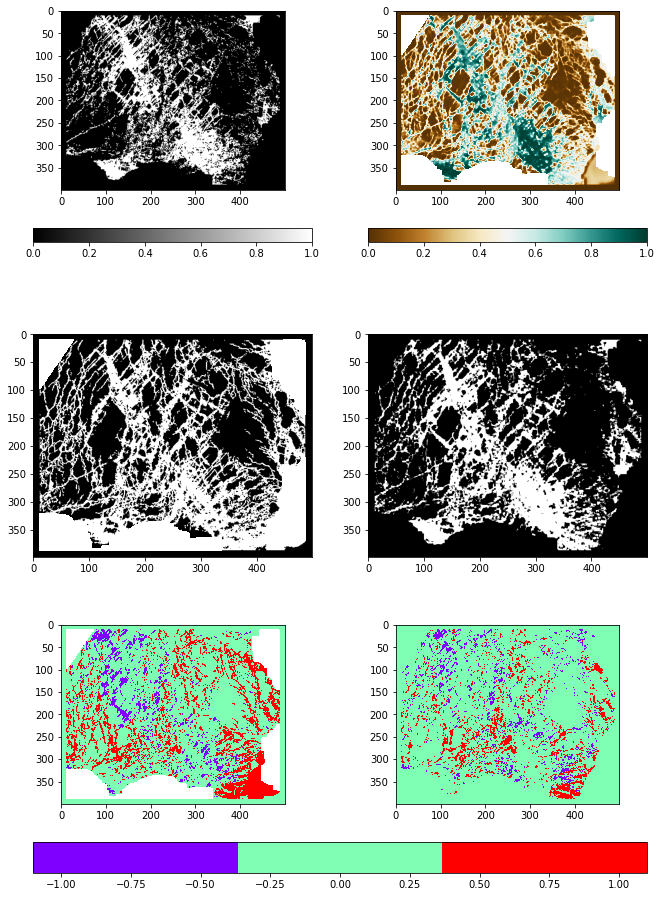

In [24]:
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(11,16))
delta_jb = y2_jb-(y2_test>dmod['target_th']).astype('float')
delta_ak = y2_ak-(y2_test>dmod['target_th']).astype('float')
delta_pred = y_nn_test-(y2_test>dmod['target_th']).astype('float')

#Mask values below the threshold
#delta_jb[y2_test<th_dam] = np.nan
#delta_ak[y2_test<th_dam] = np.nan
#delta_pred[y2_test<th_dam] = np.nan

labeled = ax[0,0].imshow(y2_test>dmod['target_th'],vmin=0, vmax=1, cmap='gray')
prob = ax[0,1].imshow(y2_pred,vmin=0, vmax=1, cmap='BrBG')
#ax[0,1].imshow(y2_test,vmin=lims['damage'][0], vmax=lims['damage'][1],cmap='jet')
ax[1,1].imshow(y_nn_test,vmin=0, vmax=1, cmap='gray')
ax[1,0].imshow(y2_jb,vmin=0, vmax=1, cmap='gray')
err = ax[2,0].imshow(delta_jb,vmin=-1.1,vmax=1.1,cmap=plt.get_cmap('rainbow',3))
ax[2,1].imshow(delta_pred,vmin=-1.1,vmax=1.1,cmap=plt.get_cmap('rainbow',3))

fig.colorbar(err, ax=ax[2,:].ravel().tolist(),orientation='horizontal');
fig.colorbar(labeled, ax=ax[0,0],orientation='horizontal');
fig.colorbar(prob, ax=ax[0,1],orientation='horizontal');

#fig.colorbar(defor, ax=ax[0,0],orientation='horizontal');
#fig.colorbar(dam, ax=ax[0,1],orientation='horizontal');


## 6. Interpretability of the CNN model

### 6.1 Feature importance using feature permutation
Let consider a n feature predictors $f(x^1,\cdots,x^n)$
We can compute the base score of the model on a set of data (e.g. validation dataset) $(X_k,y_k)$:
where $X_k = (x_k^1,\cdots,x_k^n)$
$$
S^o = {\rm score}\left(f(X_{1:K},y_{1:K})\right)
$$
In the following the score used is the correlation.

To evaluate the impact of a predictor feature, we randomly shuffle the input feature in the validation dataset. Shuffled feature is denoted $\tilde{x}^i$, and we define $X^i_k = (x_k^1,\cdots,\tilde{x}_k^i,\cdots,x_k^n)$.

The importance of the feature is evaluated by the decrease after calculated the new score:
$$
S^i = {\rm score}\left(f(X_{1:K}^i,y_{1:K})\right)
$$



In [38]:
# Define input and output features of the validation set
X_sk = Xval
y_sk = yval>dmod['target_th']

# Define the score
def score_nn (X, y):
    ypredict = model.predict(X)>.5
    return accuracy_score(y.ravel(), ypredict.ravel())

# Compute the score of each feature (the computation is done n_iter times corresponding to n_iter different random shuffle)
base_score, score_decreases = get_score_importances(score_nn, 
                                                    X_sk, 
                                                    y_sk, 
                                                    n_iter=10, 
                                                    pre_shuffle=True
                                                   )

# Compute the mean importance of each input feature
score_mean = np.mean(score_decreases, axis=0)
score_std = np.std(score_decreases, axis=0)


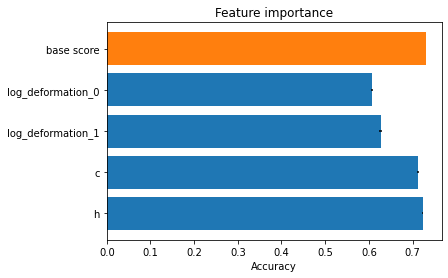

In [39]:
# Plot the importance
y_pos = np.arange(len(colnames)+1)
fig, ax = plt.subplots()

ax.barh(y_pos[1:], base_score-score_mean, xerr=score_std, align='center')
ax.barh(y_pos[0],base_score)
ax.set_yticks(y_pos);
ax.set_yticklabels(('base score',)+colnames)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.set_title('Feature importance');

### 6.2 Saliency maps
Let's consier the predictor $y=f(x^1,\cdots,x^n)$

For each input feature image $x^i$, we compute the saliency map defined by
$$
s = \frac{\partial y}{\partial x^i}
$$
The value of the saliency map represents the sensitivity of the output of the model with respect to this input.

Finally, we compute the average saliency map over multiple samples

In [40]:
from tf_keras_vis.saliency import Saliency
saliency = Saliency(model,
                    model_modifier=None,
                    clone=False)

In [41]:
#Number of sample used to calculate the saliency map
n_sample = 2000

# Define the loss for the gradient computation
def loss(output):
    return tuple(output[i] for i in range(n_sample))

# Compute the saliency map for each input feature (keepdims=True)
saliency_map = saliency(loss, Xval[:n_sample], keepdims=True)

# Compute the average saliency map
saliency_absmean = np.abs(saliency_map).mean(axis=0)

# To be used to normalize the saliency map with the standard deviation
sigma_in = np.sqrt(model.layers[2].variance.numpy())


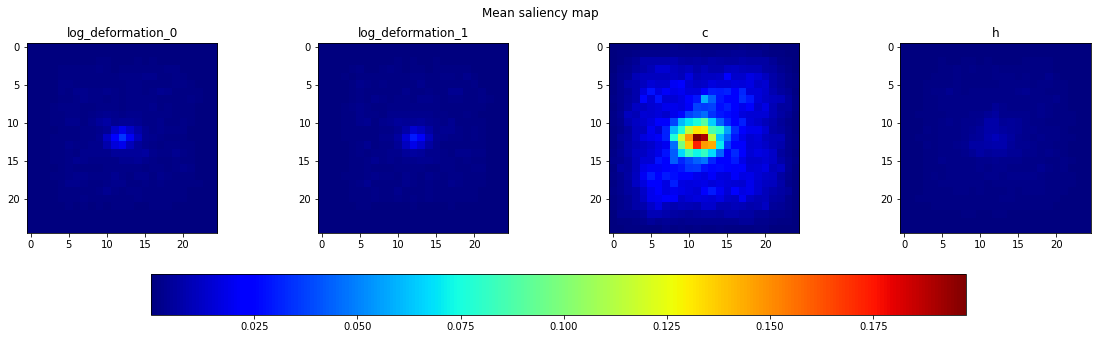

In [42]:
nc = len(exp_dict['colnames'])
vmax = saliency_absmean.max()
fig, ax = plt.subplots(ncols=nc,figsize=(5*nc,5))
for i in range(nc):
    im = ax[i].imshow(saliency_absmean[...,i], cmap='jet', vmax = vmax)
    ax[i].set_title(exp_dict['colnames'][i])
    
fig.colorbar(im, ax=ax.ravel().tolist(),orientation='horizontal');
fig.suptitle ('Mean saliency map');

In [39]:
#TODO ?
#- saliency binned
#- saliency good prediction/bad predictions